In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm

# to generate the full matrix of input data from a list of possibilities
import itertools 

# to sanity check some pymc3 results against normal logistic regression results
from sklearn.linear_model import LogisticRegression 

# to enable saving traces that take a long time to generate
import pickle

In [4]:
pd.set_option('display.max_rows', 500)

**TODO** Add in all sections before code

# Load and prep Pew poll data

In [8]:
# TODO move to local dir and check in when it looks good
d = pd.read_csv('~/OneDrive/Personal/School/Master\'s/DATA 512/Project/Oct16/pew_poll.csv')
d.shape

(2583, 6)

In [9]:
d[:2]

,state,sex,q10horseGP,race3m1,race3m2,weight
0,Minnesota,Male,Trump/lean Trump,"White (e.g., Caucasian, European, Irish, Itali...",NaN,2.088235
1,Delaware,Female,Clinton/lean Clinton,"White (e.g., Caucasian, European, Irish, Itali...",NaN,1.264706


In [10]:
#from collections import defaultdict
racethn_to_index = {
    "White (e.g., Caucasian, European, Irish, Italian, Arab, Middle Eastern)": 1,
    "Black or African-American (e.g., Negro, Kenyan, Nigerian, Haitian)": 2,
    "Asian or Asian-American (e.g., Asian Indian, Chinese, Filipino, Vietnamese or other Asian origin groups)": 3,
    "Some other race (SPECIFY____ IF NEEDED: What race or races is that?)": 4,
    "Native American/American Indian/Alaska Native (VOL.)": 5,
    "Pacific Islander/Native Hawaiian (VOL.)": 6,
    "Hispanic/Latino (VOL.) (e.g., Mexican, Puerto Rican, Cuban)": 7,
    "Don't know (VOL.)": 8,
    "Refused (e.g., non-race answers like American, Human, purple) (VOL.)": 9
}

d['race3m1_index'] = d['race3m1'].map(racethn_to_index)
d['race3m2_index'] = d['race3m2'].map(racethn_to_index)

In [11]:
def get_racecmb(row):
    if ((row['race3m2_index'] > 0) & (row['race3m2_index'] < 8)):
        return 'Mixed Race'
    elif (row['race3m1_index'] == 1):
        return 'White'
    elif (row['race3m1_index'] == 2):
        return 'Black or African-American'
    elif (row['race3m1_index'] == 3):
        return 'Asian or Asian-American'
    elif (row['race3m1_index'] >= 4 & row['race3m1_index'] <= 7):
        return 'Or some other race'
    elif ((row['race3m1_index'] >= 8) & (row['race3m1_index'] <= 9)):
        return 'Dont know/Refused (VOL.)'

In [12]:
d['racecmb'] = d.apply(get_racecmb, axis=1)

In [13]:
d['racecmb'].value_counts(dropna=False)

White                        1935
Black or African-American     258
Or some other race            230
Asian or Asian-American        83
Mixed Race                     77
Name: racecmb, dtype: int64

**TODO** sanity check above numbers... are they right?

In [16]:
d['q10horseGP'].value_counts(dropna=False)

Clinton/lean Clinton     972
Trump/lean Trump         858
Not registered           466
Johnson/lean Johnson     124
DK-refused to lean        76
Stein/lean Stein          57
Other-refused to lean     30
Name: q10horseGP, dtype: int64

In [17]:
d_only = d[(d['q10horseGP'] == 'Clinton/lean Clinton') | 
           (d['q10horseGP'] == 'Trump/lean Trump')]
d_only.shape

(1830, 9)

In [18]:
d_only['q10horseGP'].value_counts(dropna=False)

Clinton/lean Clinton    972
Trump/lean Trump        858
Name: q10horseGP, dtype: int64

**TODO** note revisit of states now that we've filtered.

In [24]:
len(d_only['state'].unique())

50

Talk about how we should have 51...

In [25]:
d_only['state'].value_counts(dropna=False)

California              158
Texas                   133
Florida                 123
New York                121
Pennsylvania             75
Ohio                     72
New Jersey               68
Georgia                  62
Michigan                 61
North Carolina           61
Virginia                 60
Illinois                 57
Minnesota                48
Arizona                  45
Washington               45
Wisconsin                43
Tennessee                37
Kentucky                 34
Missouri                 34
Colorado                 33
Indiana                  33
South Carolina           33
Maryland                 30
Oregon                   29
Louisiana                28
Massachusetts            28
Oklahoma                 26
Alabama                  22
Iowa                     19
Kansas                   19
Nevada                   18
Idaho                    18
Connecticut              17
West Virginia            15
Utah                     15
Mississippi         

In [26]:
d_only[d_only['state'] == 'South Dakota']

,state,sex,q10horseGP,race3m1,race3m2,weight,race3m1_index,race3m2_index,racecmb


We don't have any rows in our two-party data w/ South Dakota, so absent any extra work on our part, we won't have a dummy indicator variable for SD, which'll make it harder to do stuff w/ the state later. We'll add it here when we're forming the dummies w/ states.

In [28]:
# add South Dakota, using the same index to make sure we don't extra cols (prob a better way to do this)
state_dummies = pd.concat([pd.get_dummies(d_only['state']), 
                           pd.Series(name='South Dakota', data=np.repeat(0, len(d_only)), index=d_only.index)], axis=1)
# alphabetize to put SD in the right spot
state_dummies = state_dummies.reindex(sorted(state_dummies.columns), axis=1)
state_dummies.shape

(1830, 51)

In [29]:
state_count = len(state_dummies.columns.values)
state_count

51

In [45]:
state_number_to_name = dict(list(zip(range(0,51), sorted(state_dummies.columns.values))))
state_number_to_name

{0: 'Alabama',
 1: 'Alaska',
 2: 'Arizona',
 3: 'Arkansas',
 4: 'California',
 5: 'Colorado',
 6: 'Connecticut',
 7: 'Delaware',
 8: 'District of Columbia',
 9: 'Florida',
 10: 'Georgia',
 11: 'Hawaii',
 12: 'Idaho',
 13: 'Illinois',
 14: 'Indiana',
 15: 'Iowa',
 16: 'Kansas',
 17: 'Kentucky',
 18: 'Louisiana',
 19: 'Maine',
 20: 'Maryland',
 21: 'Massachusetts',
 22: 'Michigan',
 23: 'Minnesota',
 24: 'Mississippi',
 25: 'Missouri',
 26: 'Montana',
 27: 'Nebraska',
 28: 'Nevada',
 29: 'New Hampshire',
 30: 'New Jersey',
 31: 'New Mexico',
 32: 'New York',
 33: 'North Carolina',
 34: 'North Dakota',
 35: 'Ohio',
 36: 'Oklahoma',
 37: 'Oregon',
 38: 'Pennsylvania',
 39: 'Rhode Island',
 40: 'South Carolina',
 41: 'South Dakota',
 42: 'Tennessee',
 43: 'Texas',
 44: 'Utah',
 45: 'Vermont',
 46: 'Virginia',
 47: 'Washington',
 48: 'West Virginia',
 49: 'Wisconsin',
 50: 'Wyoming'}

In [30]:
d_only_dummies = pd.concat([pd.get_dummies(d_only['sex'], drop_first=True),
                            pd.get_dummies(d_only['racecmb']),
                            state_dummies], axis=1)
d_only_dummies.shape

(1830, 57)

In [31]:
d_only_dummies[:2]

,Male,Asian or Asian-American,Black or African-American,Mixed Race,Or some other race,White,Alabama,Alaska,Arizona,Arkansas,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Model

In [19]:
y_obs_categorical = pd.Categorical(d_only['q10horseGP'])
y_obs = y_obs_categorical.codes

sum(y_obs == 0), sum(y_obs == 1)

(972, 858)

In [20]:
y_obs_categorical

[Trump/lean Trump, Clinton/lean Clinton, Trump/lean Trump, Trump/lean Trump, Clinton/lean Clinton, ..., Trump/lean Trump, Clinton/lean Clinton, Clinton/lean Clinton, Clinton/lean Clinton, Clinton/lean Clinton]
Length: 1830
Categories (2, object): [Clinton/lean Clinton, Trump/lean Trump]

Clinton is 0, Trump is 1.

**TODO** Note when writing docs that I have a lot of simpler and other models in the research notebook, and that I'm only showing the final one here.

In [34]:
vals_sex = d_only_dummies.values[:,0]
vals_racecmb = d_only_dummies.values[:,1:6]
vals_state = d_only_dummies.values[:,6:]

vals_sex.shape, vals_racecmb.shape, vals_state.shape

((1830,), (1830, 5), (1830, 51))

In [35]:
with pm.Model() as model_complete:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sd=10)
    
    mu_race = pm.Normal('mu_race', mu=0, sd=10)
    sigma_race = pm.HalfCauchy('sigma_race', 5)
    beta_race = pm.Normal('beta_race', mu=mu_race, sd=sigma_race, 
                          shape=len(d_only['racecmb'].unique()))
    
    mu_state = pm.Normal('mu_state', mu=0, sd=10)
    beta_state = pm.Normal('beta_state', mu=mu_state, sd=10, 
                          shape=state_count)

    mu = alpha + \
         vals_sex * beta_sex + \
         pm.math.dot(vals_racecmb, beta_race) + \
         pm.math.dot(vals_state, beta_state)
            
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    y = pm.Bernoulli('y', theta, observed=y_obs)

**P! TODO** I could try w/ smaller SDs (5), and with potentially diff priors, perhaps think further about how to get more shrinkage, etc?

In [37]:
with model_complete:
    trace_complete = pm.sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 1999/2000 [15:44<00:00,  2.09it/s]/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
100%|██████████| 2000/2000 [15:44<00:00,  2.12it/s]


In [38]:
varnames_model_complete = ['alpha', 'beta_sex', 
                           'mu_race', 'sigma_race', 'beta_race',
                           'mu_state', 'beta_state']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d49da58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1224eb5c0>]], dtype=object)

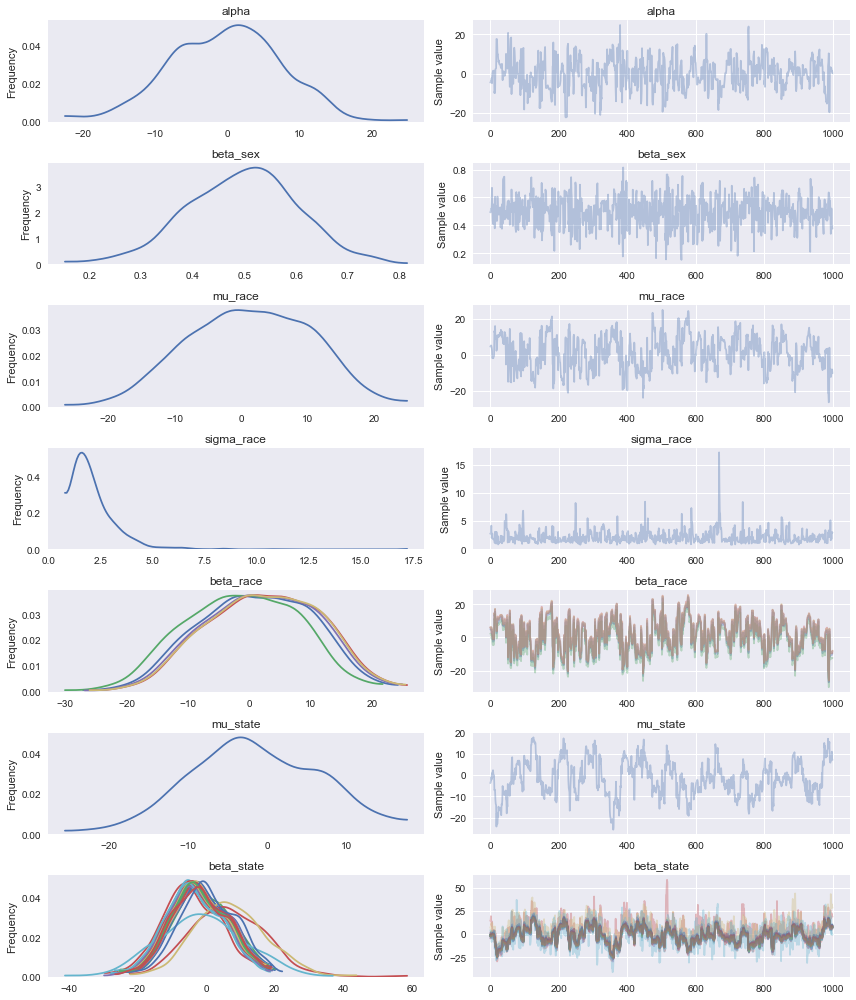

In [41]:
pm.traceplot(trace_complete, varnames_model_complete)

In [42]:
pm.df_summary(trace_complete, varnames_model_complete)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.221973,7.632856,0.446122,-14.834579,13.628021
beta_sex,0.495122,0.106877,0.003910,0.260966,0.686831
mu_race,1.197416,9.140967,0.658625,-15.038664,18.964582
sigma_race,2.176263,1.173840,0.064077,0.851541,4.203773
beta_race__0,0.951417,9.161868,0.661145,-15.159310,18.747300
beta_race__1,-1.343700,9.154045,0.658406,-19.101273,14.810353
beta_race__2,2.399361,9.157081,0.659968,-13.518215,20.335024
beta_race__3,1.943100,9.148041,0.658333,-14.331996,19.582283
beta_race__4,2.299098,9.144476,0.658484,-14.405819,19.570592
mu_state,-1.666314,8.183797,0.722582,-16.763944,14.705873


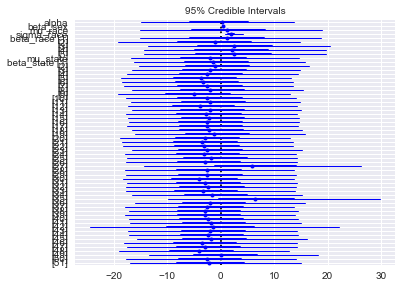

In [43]:
pm.forestplot(trace_complete, varnames_model_complete)

# Predictions

generate full set of cell input data

In [46]:
all_cells_list = list(itertools.product(np.sort(d_only['sex'].unique()), 
                                        np.sort(d_only['racecmb'].unique()),
                                        sorted(state_number_to_name.values())))
all_cells_list[:2]

[('Female', 'Asian or Asian-American', 'Alabama'),
 ('Female', 'Asian or Asian-American', 'Alaska')]

In [47]:
len(all_cells_list)

510

In [48]:
all_cells = pd.DataFrame(all_cells_list, columns=['sex','racecmb','state'])
all_cells[:2]

,sex,racecmb,state
0,Female,Asian or Asian-American,Alabama
1,Female,Asian or Asian-American,Alaska


In [49]:
# remove sex_Female since we only need one col for sex
all_cells_dummies = pd.get_dummies(all_cells).drop('sex_Female', 1)
all_cells_dummies[:3]

,sex_Male,racecmb_Asian or Asian-American,racecmb_Black or African-American,racecmb_Mixed Race,racecmb_Or some other race,racecmb_White,state_Alabama,state_Alaska,state_Arizona,state_Arkansas,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


predictions

In [52]:
def standard_logistic(x):
    return 1 / (1 + np.exp(-x))

def classify_with_matrix(values_matrix, threshold, trace_data, varnames, add_intercept=False):
    if add_intercept:
        # add a column at the beginning with all ones, to match up w/ something like an alpha param
        values_matrix = np.c_[np.ones(len(values_matrix)), values_matrix]

    mean_vals = pm.df_summary(trace_data, varnames)['mean'].values

    mu = np.dot(values_matrix, mean_vals)

    prob = standard_logistic(mu)
    return prob, prob > threshold

In [53]:
probs, _ = classify_with_matrix(all_cells_dummies, 0.5, trace_complete,
                                ['alpha','beta_sex','beta_race','beta_state'], add_intercept=True)
probs.shape

(510,)

In [54]:
all_cells['trump_prob'] = probs
all_cells.shape

(510, 4)

In [55]:
all_cells[:2]

,sex,racecmb,state,trump_prob
0,Female,Asian or Asian-American,Alabama,0.431263
1,Female,Asian or Asian-American,Alaska,0.538342


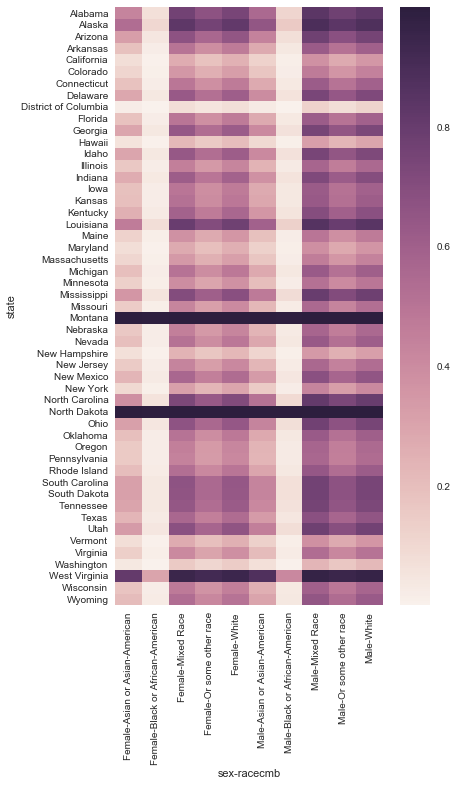

In [56]:
plt.figure(figsize=(6,11))
sns.heatmap(all_cells.pivot_table(columns=['sex','racecmb'],index='state',values='trump_prob'))

# CPS data